In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.ion()

In [3]:
landmarks_frame = pd.read_csv('data_set/faces/face_landmarks.csv')
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [15]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print(f'Image name {img_name}')
print(f'Landmarks shape {landmarks.shape}')
print(f'First 4 Landmarks {landmarks[:4]}')
print(f'landmarks type{type(landmarks)}')

Image name person-7.jpg
Landmarks shape (68, 2)
First 4 Landmarks [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]
landmarks type<class 'numpy.ndarray'>


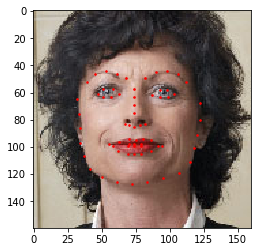

In [6]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)
    
plt.figure()
show_landmarks(io.imread(os.path.join('data_set/faces', img_name)), landmarks)

In [7]:
class FaceLandmarksDataset(Dataset):
    '''Face Landmarks dataset.'''
    
    def __init__(self, csv_file, root_dir, transform=None):
        '''
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (stirng): Directory with all the images.
            transform (callable, optional): Optional transform be applied on a sample
        '''
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

0 (324, 215, 3) (68, 2)


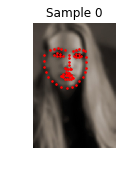

1 (500, 333, 3) (68, 2)


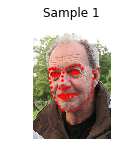

2 (250, 258, 3) (68, 2)


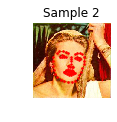

3 (434, 290, 3) (68, 2)


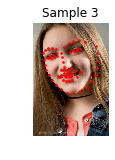

In [14]:
face_dataset = FaceLandmarksDataset(csv_file='data_set/faces/face_landmarks.csv', root_dir='data_set/faces')
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(f'{i} {sample["image"].shape} {sample["landmarks"].shape}')
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title(f'Sample {i}')
    ax.axis('off')
    show_landmarks(**sample)
    if i==3:
        plt.show()
        break


In [24]:
class Rescale(object):
    '''Rescale the image in a sample to a given size
    Args:
        output_size(tuple or int): Desired output size. If tuple, output is matched to output_size.
        If int, smaller of image is matched to output_size keeping aspect ratio the same.
    '''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size*h/w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size*w/h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks*[new_w/w, new_h/h]
        return {'image': img, 'landmarks': landmarks}
        
        
        
class RandomCrop(object):
    '''Crop randomly the image in a sample.
    Args:
        output_size (tuple or int): Desired output size. If int, quare crop is made
    '''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h , new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top:top+new_h, left:left+new_w]
        
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}
    

class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        image = image.transpose((2, 0, 1))
        return {
            'image': torch.from_numpy(image), 
            'landmarks': torch.from_numpy(landmarks)
        }


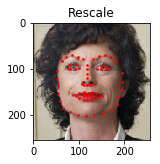

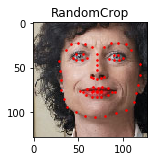

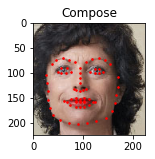

In [25]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()